In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

The network consists of a single layer of 180 neurons that receive activation from both exogenous inputs and lateral connections.

### Input activation
#### equation (7)

On simulated trial *n*, the mean input activation to neuron *i* is a function of the difference between the target location *$\theta(n)$* and the preferred direction of the neuron *$\theta_i^*$*


target: *$I_i(n)$*, mean activation of unit i  
baseline: *$I_0$*, baseline input rate  
gain: *$\gamma$*, input gain  
target: *$\theta(n)$*,  target location  
preference: *$\theta_i^*$*, prefered direction of unit i  
spread: *$\omega_I$*, spread of input activation (full-width-half-magnitude / FWHM)  


In [122]:
# define input activation function

def input_activation(target, preference, baseline=0, gain=1, spread=12):
    activation = baseline + gain * np.exp(-np.log(2) * ((target-preference) / (spread/2))**2)    
    return activation



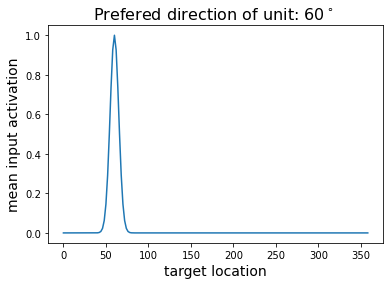

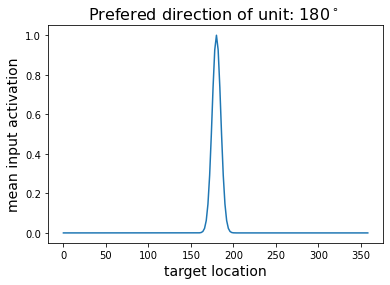

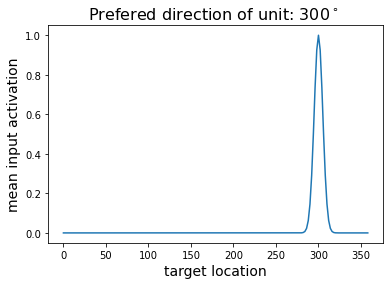

In [123]:
# Plot activation profile for and example unit

def plot_input_activation_profile(prefered_direction, baseline=0, gain=1, spread=12):
    # calculate activation for all orientations between 0 and 360 degrees
    target = np.arange(0,360,2)
    activation = np.zeros(len(target))

    for ii in range(len(target)):
        activation[ii] = input_activation(target[ii], prefered_direction)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(target, activation)
    plt.xlabel('target location', fontsize=14)
    plt.ylabel('mean input activation', fontsize=14)
    plt.title('Prefered direction of unit: %d$^\circ$ ' %prefered_direction, fontsize=16)
    
for pref in[60, 180, 300]:
    plot_input_activation_profile(pref, baseline=0, gain=1, spread=12)

### Trial iteration
#### equation (8)

For network simulations, the dynamics of the network were iterated five times for each trial.

[*I think we can consider leaving this iteration detail out to begin with. This will also simplify equations 10 and 11]

### Lateral connection strength
#### equation (9)

The initial connection strength between a pair of units is determined by the distance between the units’ preferred directions in the circular space (preferred directions were evenly spaced at delta = 2 degrees)  

W_ij: *$W_{ij}$* lateral connection strength (unit j to unit i)  
pref_i: *$\theta_i^*$*, prefered direction of unit i  
pref_j: *$\theta_j^*$*, prefered direction of unit j  
spread: *$\omega_L$*, full-width-half-magnitude (FWHM)

In [99]:
# define lateral connection strength function

def connection_strength(pref_i, pref_j, spread=30):
    W_ij = np.exp(-np.log(2) * ((pref_i-pref_j) / (spread/2))**2)    
    return W_ij

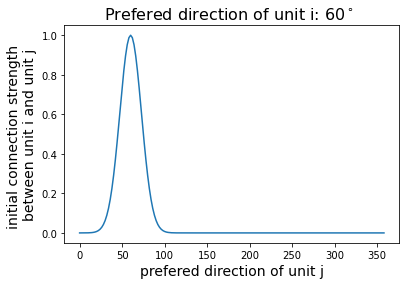

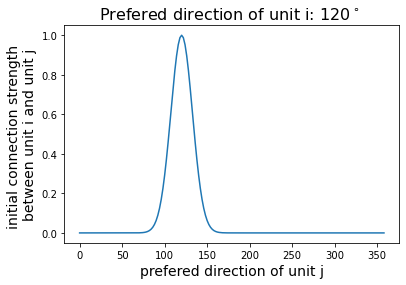

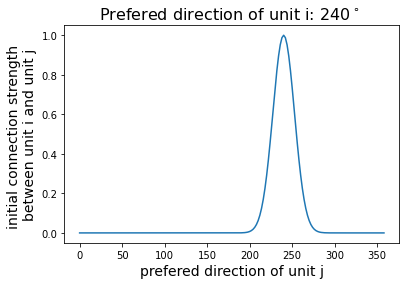

In [119]:
# Plot activation profile for and example unit

def plot_connection_strength_profile(pref_i, spread=30):
    # calculate connection
    pref_j = np.arange(0,360,2)
    W_ij = np.zeros(len(pref_j))

    for j in range(len(pref_j)):
        W_ij[j] = connection_strength(pref_i, pref_j[j], spread)

    # plot input activation    
    ax, fig = plt.subplots()
    plt.plot(pref_j, W_ij)
    plt.xlabel('prefered direction of unit j', fontsize=14)
    plt.ylabel('initial connection strength \nbetween unit i and unit j', fontsize=14)
    plt.title('Prefered direction of unit i: %d$^\circ$ ' %pref_i, fontsize=16)
    
for pref_i in[60, 120, 240]:
    plot_connection_strength_profile(pref_i, spread=30)

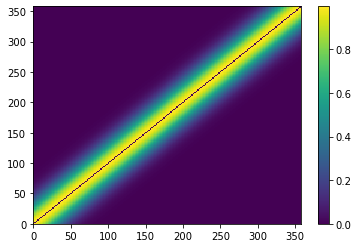

In [124]:
# create and plot an example initial weight matrix

# define 180 units
preference = np.arange(0,360,2)

# calc weight between units
W = np.zeros([len(preference), len(preference)])
for i, pref_i in enumerate(preference):
    for j, pref_j in enumerate(preference):
        W[i,j] = connection_strength(i, j)
        
        # force zero value on the diagonal?
        # [should the diagonal be zero?]
        if pref_i == pref_j: 
            W[i,j] = 0

# plot weights
plt.pcolormesh(preference, preference, W)
plt.colorbar()

### Total Activation
#### equation (10)

On each iteration *t*, the total activation for unit *i* was then computed as the sum of the input and recurrent activations

In [386]:
def total_activation(firing_rate, weights, theta, preference):    
    # calc total activation
    total_activation = input_activation(theta, preference) + np.dot(weights, firing_rate)
    
    return total_activation


<BarContainer object of 180 artists>

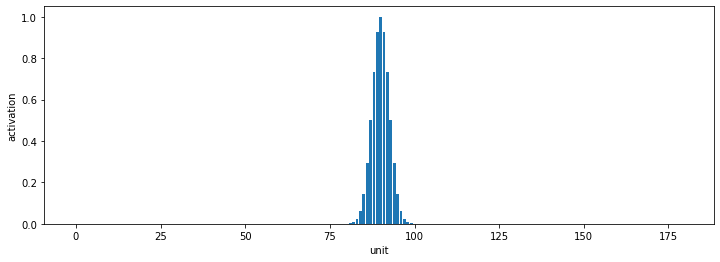

In [399]:
# calc input activation example
THETA = 180
X = np.zeros_like(preference)

U = lambda preference: total_activation(X, W, THETA, preference)

act = U(preference)

plt.figure(figsize=[12,4])
plt.xlabel('unit')
plt.ylabel('activation')
plt.bar(np.arange(180), act)

### Firing Rates
#### equation (11)

Total activation was normalized on each iteration to obtain the new firing rates

In [402]:
def norm_activation(activation, a=0.002, b=0.001):
    norm = np.zeros_like(activation)
    for ii, act in enumerate(activation):
        norm[ii] = act**2 / (a + b * np.sum(activation**2))
    return norm  

### Hebbian learning rule
#### equation (12) 

After each iteration, the recurrent weights Wij were updated using a
normalized Hebbian learning rule [(Oja, 1982)](https://link.springer.com/article/10.1007/BF00275687)

beta: *$\beta$* learning rate  
alpha: *$\alpha$* normalization parameter  
weights: *$W_{ij}$*, synaptic weights  
updated_weights: *$W_{ij, t+1}$*; updated weight  
X: firing rates

In [337]:
def update_weights(weights, X, beta=1, alpha=1):
    updated_weights = weights + beta*(np.outer(X, X) - alpha*(weights*X**2))
    
    return updated_weights

### Estimated Movement Vector
#### equation (13) 

[Georgopoulos, 1988](https://www.jneurosci.org/content/8/8/2928)

In [ ]:
theta_mv = np.arctan(np.sum(np.cos(theta_star_i .- np.sin(theta_star_i))))

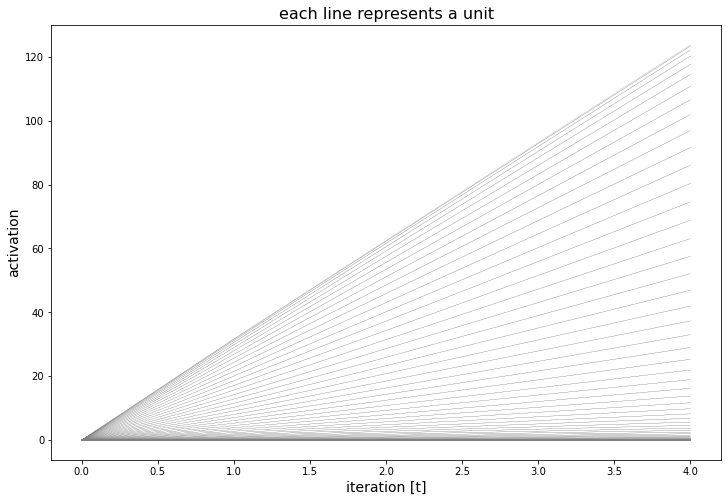

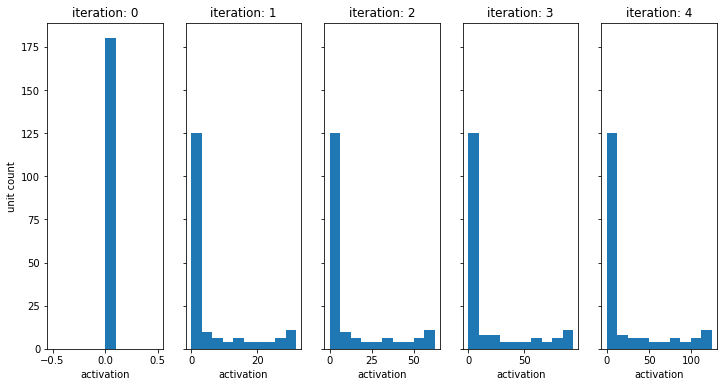

In [404]:
# begin by building model with fixed weights

def bayesian_fixed_weights(firing_rate, t, theta, preference, weights):
    
    # calc total activation
    total_activation = input_activation(theta, preference) + np.dot(weights, firing_rate)

    # normalize activation
    firing_rate = norm_activation(total_activation)
    
    return firing_rate
       
    
# define input angle
THETA = 180

# define time vactor
t = np.linspace(1,100,100)

# define 180 units
preference = np.arange(0,360,2)

# define time vector (iterations)
n_iterations = 5
t = np.linspace(0,n_iterations-1,n_iterations)

# initial conditions
y0 = np.zeros_like(preference)

# solve
sol = odeint(bayesian_fixed_weights, y0, t, args=(THETA, preference, W))


# plot results
plt.figure(figsize=[12,8])
plt.plot(t, sol, 'grey', linewidth=0.2)
plt.xlabel('iteration [t]', fontsize=14)
plt.ylabel('activation', fontsize=14)
plt.title('each line represents a unit', fontsize=16)
plt.show()


fig, ax = plt.subplots(1,5, figsize=[12,6], sharey='all')
ax[0].set(ylabel='unit count')
for i in range(n_iterations):
    ax[i].hist(sol[i])
    ax[i].set(xlabel='activation')
    ax[i].set(title='iteration: %d' %i)
plt.show()


In [408]:
# this dont work yet...

def adaptive_bayesian(y, t, theta, preference):
    firing_rate, weights = y
    
    # calc total activation
    activation = total_activation(firing_rate, weights, theta, preference)

    # normalize activation
    firing_rate = norm_activation(activation)
    
    # update weights
    weights = update_weights(weights, firing_rate)
    
    # update values to return
    dy = [firing_rate, weights]
    
    return dy

# initial conditions
y0 = [np.zeros_like(preference), np.zeros_like(W)]

# solve
sol = odeint(adaptive_bayesian, y0, t, args=(THETA, preference))


# plot results
plt.figure(figsize=[12,8])
plt.plot(t, sol, 'grey', linewidth=0.2)
plt.xlabel('iteration [t]', fontsize=14)
plt.ylabel('activation', fontsize=14)
plt.title('each line represents a unit', fontsize=16)
plt.show()


fig, ax = plt.subplots(1,5, figsize=[12,6], sharey='all')
ax[0].set(ylabel='unit count')
for i in range(n_iterations):
    ax[i].hist(sol[i])
    ax[i].set(xlabel='activation')
    ax[i].set(title='iteration: %d' %i)
plt.show()

ValueError: could not broadcast input array from shape (180,180) into shape (180)